# Necessary Imports

In [1]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
import pickle
import time
import sys

# Webscraping
These code blocks create an instance of the webscraper object, and scrapes levelsfyi for its data using a selenium driver

In [2]:
class WebScraper():
    def __init__(self):
        serv = Service('/usr/bin/chromedriver')
        self.auth = False
        self.driver = webdriver.Chrome(service=serv)
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []
        self.soup = None

    # initializes the client to levels.fyi
    def initialize_client(self):
        url = 'https://www.levels.fyi/companies/google/salaries/software-engineer?offset=0'
        self.driver.get(url)
        return

    #function that removes the blur from the salary list
    def remove_blur(self):
        # click buttons to remove the blur from salary data
        self.driver.execute_script("document.querySelector('.css-kg5r73').scrollIntoView();")
        self.driver.execute_script("document.querySelector('.css-1q3lwpg').click();")
        self.driver.execute_script("document.querySelector('.css-boyo6o').click();")
        self.auth = True
        return

    #function to filter salaries to United States only
    def filter_country(self):
        # opening dropdown
        self.driver.execute_script("document.querySelector('.css-ch9u3p').click();")

        # scroll United States into view
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-wbg7z3 li');
            let us = buttons[buttons.length-1].querySelector('label span input');
            us.scrollIntoView();
        """)
        action = ActionChains(self.driver)
        us = self.driver.find_elements(By.CSS_SELECTOR,'.css-wbg7z3 li')[-1]
        action.click(us)
        action.perform()

    #function that increases the dropdown limit to 50
    def increase_limit(self):
        # increase rows per page to 50
        self.driver.execute_script("document.querySelector('.css-1wxoufr').click();")
        action = ActionChains(self.driver)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.perform()
        time.sleep(5)
        return

    #expands all salary entries
    def expand_entries(self):
        # click all the salary dropdown buttons
        self.driver.execute_script("""
            let dropDowns = document.querySelectorAll(".css-5mf6ol");
            for (const dropDown of dropDowns){
                dropDown.click();
            };
        """)
        time.sleep(2)
        return

    #function that gets the next page of salaries
    def get_next_page(self):
        #get the page buttons and click the > one
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-pvt3pn');
            buttons[buttons.length-1].click();
        """)
        return

    #updates soup object of the page
    def get_soup(self):
        html = self.driver.page_source
        self.soup = bs(html,'html.parser')
        return

    #function to create soup object of page, and collect data
    def collectData(self):
        #all salary elements
        self.salaries_list += [s.text.strip() for s in self.soup.select('.css-10sgg15')]

        #get 'level' elements
        self.levels_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_flexRow__yvqab .expanded-salary-view_levelContainer__N_p7A p')]

        # get date hired elements
        self.offer_date_list += [window.select('.expanded-salary-view_detailField__giEDA')[2].select('p')[0].text for window in self.soup.select('.css-1mpid8k')]

        # get years at company elements
        self.years_at_company_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsAtCompanyTextContainer__2BwXQ div p')]

        # get years of experience elements
        self.years_of_experience_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsOfExperienceTextContainer__VuXhv div p div')]

        return

    # clear data
    def clear_data(self):
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []

    # function that performs a full scrape of the levels fyi google salaries
    def scrape(self):
        self.clear_data()
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.increase_limit()
        self.filter_country()
        self.expand_entries()
        self.get_soup()
        self.collectData()
        for i in range(19):
            self.get_next_page()
            time.sleep(1)
            self.expand_entries()
            self.get_soup()
            self.collectData()

    # collects the soup of just one page for testing purposes
    def one_soup(self):
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.filter_country()
        self.increase_limit()
        self.expand_entries()
        self.get_soup()

    def print_data(self):
        print(f'Salaries: Count = {len(self.salaries_list)}, Values = {self.salaries_list}')
        print(f'Levels: Count = {len(self.levels_list)}, Values = {self.levels_list}')
        print(f'Dates: Count = {len(self.offer_date_list)}, Values = {self.offer_date_list}')
        print(f'Years At Company: Count = {len(self.years_at_company_list)}, Values = {self.years_at_company_list}')
        print(f'Years of Experience: Count = {len(self.years_of_experience_list)}, Values = {self.years_of_experience_list}')


In [3]:
scraper = WebScraper()

In [4]:
scraper.scrape()

# Data Organizing and Cleaning with Pandas

In [5]:
d = {'Salary':scraper.salaries_list,'Level':scraper.levels_list,'Days Into Year':scraper.offer_date_list,'Years at Company':scraper.years_at_company_list,'Years of Experience':scraper.years_of_experience_list}
df = pd.DataFrame(d)
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,"$200,000",L3,Employee as of 12/04/2022,0 yr,1 yr
1,"$209,500",L4,Offer from 12/04/2022,0 yrs,5 yrs
2,"$205,000",L4,Employee as of 12/04/2022,1 yrs,5 yrs
3,"$192,500",L3,Offer from 12/04/2022,0 yrs,0 yrs
4,"$159,000",L3,Employee as of 12/03/2022,1 yr,1 yr
...,...,...,...,...,...
992,"$205,000",L3,Employee as of 08/03/2022,2 yrs,2 yrs
993,"$279,000",L4,Employee as of 08/03/2022,3 yrs,4 yrs
994,"$162,000",L4,Employee as of 08/03/2022,1 yrs,8 yrs
995,"$697,000",L5,Employee as of 08/03/2022,9 yrs,22 yrs


In [6]:
# removing all invalid job levels then converting them to integers
valid_levels = {'L3':1.0,'L4':2.0,'L5':3.0,'L6':4.0,'L7':5.0,'L8':6.0}
df = df[df.Level.isin(valid_levels)]
def convertLevel(level):
    return valid_levels[level]
df["Level"] = df["Level"].apply(convertLevel)
df.Level.value_counts()

1.0    348
2.0    330
3.0    216
4.0     62
5.0     11
6.0      4
Name: Level, dtype: int64

In [7]:
# converting the salaries to integers
def convertSalary(salary):
    return float(''.join(salary[1:].split(',')))
df["Salary"] = df["Salary"].apply(convertSalary)
df.head()

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,200000.0,1.0,Employee as of 12/04/2022,0 yr,1 yr
1,209500.0,2.0,Offer from 12/04/2022,0 yrs,5 yrs
2,205000.0,2.0,Employee as of 12/04/2022,1 yrs,5 yrs
3,192500.0,1.0,Offer from 12/04/2022,0 yrs,0 yrs
4,159000.0,1.0,Employee as of 12/03/2022,1 yr,1 yr


In [8]:
# converting the offer date to just days since January 1st. This variable could be a factor of economic trends
months = [31,28,31,30,31,30,31,31,30,31,30,31]
monthsSum = [sum(months[:i]) for i in range(len(months))]
def convertDate(date):
    date = date.split(' ')[-1].split('/')
    return monthsSum[int(date[0])-1] + float(date[1])
df["Days Into Year"] = df["Days Into Year"].apply(convertDate)

In [9]:
# convert year columns to just integer
def convertYear(year):
    return float(year.split(' ')[0])
df["Years at Company"] = df["Years at Company"].apply(convertYear)
df["Years of Experience"] = df["Years of Experience"].apply(convertYear)

In [10]:
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,200000.0,1.0,338.0,0.0,1.0
1,209500.0,2.0,338.0,0.0,5.0
2,205000.0,2.0,338.0,1.0,5.0
3,192500.0,1.0,338.0,0.0,0.0
4,159000.0,1.0,337.0,1.0,1.0
...,...,...,...,...,...
992,205000.0,1.0,215.0,2.0,2.0
993,279000.0,2.0,215.0,3.0,4.0
994,162000.0,2.0,215.0,1.0,8.0
995,697000.0,3.0,215.0,9.0,22.0


# Charting some graphs for salary

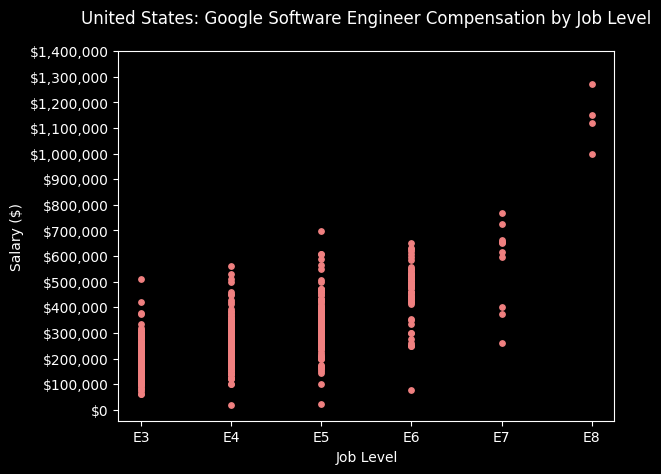

In [11]:
colors = {1:"lightcoral",2:"orange",3:"yellow",4:"palegreen",5:"skyblue",6:"plum"}
thousands = ["$0","$100,000","$200,000","$300,000","$400,000","$500,000","$600,000","$700,000","$800,000","$900,000","$1,000,000","$1,100,000","$1,200,000","$1,300,000","$1,400,000"]
plt.style.use("dark_background")

plt.scatter(df["Level"],df["Salary"],c="lightcoral",s=15)
plt.title("United States: Google Software Engineer Compensation by Job Level",pad=20)
plt.xlabel("Job Level")
plt.ylabel("Salary ($)")
plt.ticklabel_format(axis='both', style='plain')
plt.yticks([i for i in range(0,1500000,100000)],thousands)
plt.xticks([1,2,3,4,5,6],['E3','E4','E5','E6','E7','E8'])
plt.show()

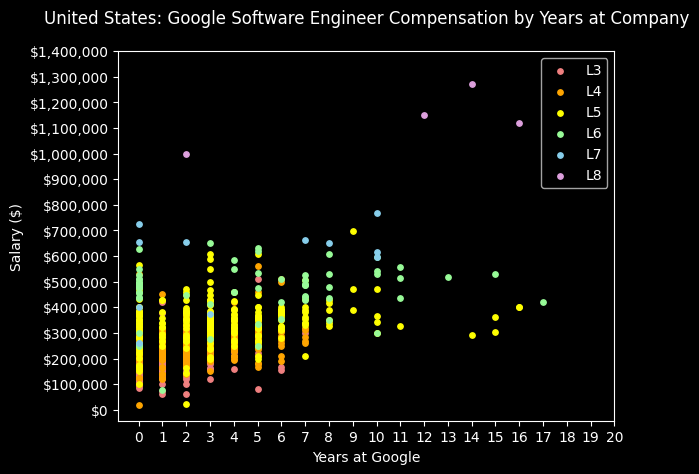

In [12]:
valid_levels = {'L3':1,'L4':2,'L5':3,'L6':4,'L7':5,'L8':6}
level_strings = {1:'L3',2:'L4',3:'L5',4:'L6',5:'L7',6:'L8'}
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Years at Company"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Years at Company",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(21)])
ax.set_xlabel("Years at Google")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

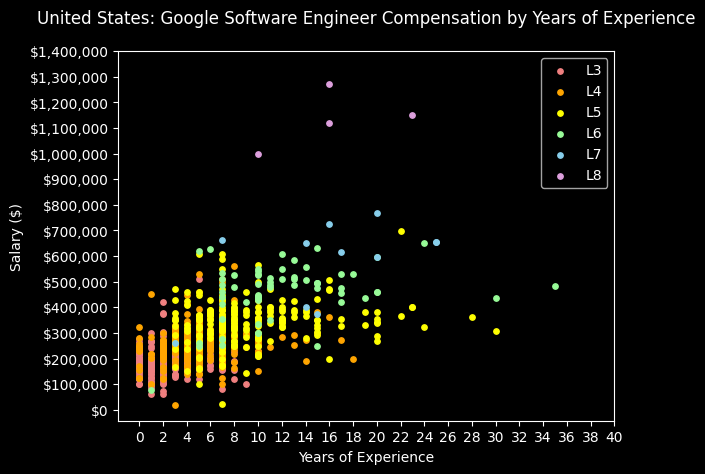

In [13]:
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Years of Experience"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Years of Experience",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(0,41,2)])
ax.set_xlabel("Years of Experience")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

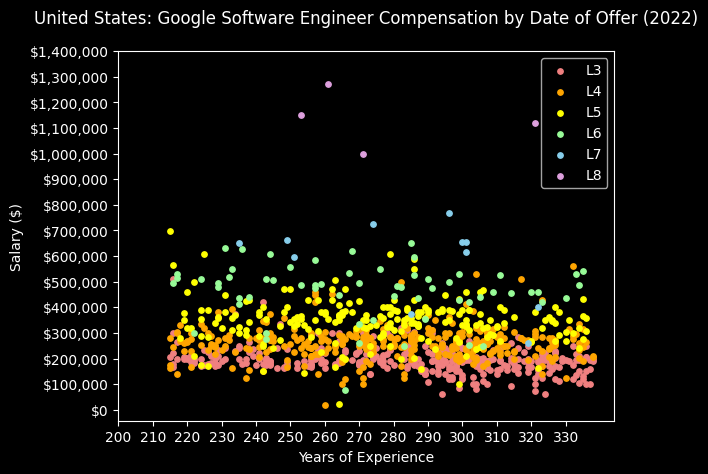

In [14]:
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Days Into Year"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Date of Offer (2022)",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(200,331,10)])
ax.set_xlabel("Years of Experience")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

# Making some machine learning models to predict a salary

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#setting a seed to so same answers every time
np.random.seed(42)
train, test = train_test_split(df, test_size=0.2)
x_train = train.drop(columns=["Salary"]).values
y_train = train["Salary"].values
x_test = test.drop(columns=["Salary"]).values
y_test = test["Salary"].values

In [42]:
linReg = LinearRegression()
linReg.fit(x_train,y_train)

LinearRegression()

In [45]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
y_test_pred = linReg.predict(x_test)
print(f'RMSE for linear regression : {mean_squared_error(y_test,y_test_pred)**(1/2)}')
print(f'R^2 for linear regression : {r2_score(y_test,y_test_pred)}')
for i in range(100):
    print(f'Actual Salary: {y_test[i]}, Predicted Salary: {y_test_pred[i]}')

RMSE for linear regression : 73008.05435012323
R^2 for linear regression : 0.5779801028280891
Actual Salary: 323000.0, Predicted Salary: 300788.0601833378
Actual Salary: 281000.0, Predicted Salary: 271424.9636378583
Actual Salary: 280000.0, Predicted Salary: 284789.2627325816
Actual Salary: 271000.0, Predicted Salary: 280904.41942182666
Actual Salary: 208000.0, Predicted Salary: 255660.81458307555
Actual Salary: 22000.0, Predicted Salary: 349659.68744408217
Actual Salary: 244903.0, Predicted Salary: 298565.444053877
Actual Salary: 264250.0, Predicted Salary: 177603.1998164047
Actual Salary: 350000.0, Predicted Salary: 343514.1558543049
Actual Salary: 350000.0, Predicted Salary: 365907.65001583035
Actual Salary: 268000.0, Predicted Salary: 296122.5714624155
Actual Salary: 213000.0, Predicted Salary: 254803.19098909947
Actual Salary: 457000.0, Predicted Salary: 420670.7216429902
Actual Salary: 185000.0, Predicted Salary: 175553.04858568902
Actual Salary: 164250.0, Predicted Salary: 16768